In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000): 
    # 데이터의 중복 제거 및 NaN 결측치 제거
    train_data.drop_duplicates(subset = ['document'], inplace=True) 
    #subset은 중복데이터를 처리할 열을 입력, inplace는 메서드가 적용되는 원본 데이터를 변경할지 여부를 결정
    train_data = train_data.dropna(how ='any')
    # how = 'any' -> NA(결측치)값이 존재하면 그 행이나 열을 drop함.
    # 참고 : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html
    test_data.drop_duplicates(subset = ['document'], inplace=True) 
    test_data = test_data.dropna(how ='any')
    
    # 한국어 토크나이저로 토큰화 및 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        # Mecab의 morphs 기능을 통해 형태소로 구문분석
        # 참고 : https://konlpy-ko.readthedocs.io/ko/v0.4.3/api/konlpy.tag/
        temp_X = [word for word in temp_X if not word in stopwords] 
        # 구분한 형태소 중 stopwords에 존재하지 않는 것만 temp_X에 저장
        X_train.append(temp_X)
        
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords] 
        X_test.append(temp_X)
    
    #?? concatenate는 배열을 붙이는 거라는 데 하나로 어떻게 합치지?
    # ndarray클래스이 tolist() 메소드를 이용해 list 객체를 구하여 words에 저장.
    words = np.concatenate(X_train).tolist() 
    # 리스트의 나온 횟수만큼 counter 리스트에 저장
    counter = Counter(words)
    # 데이터 개수가 많은 순으로 정렬된 배열을  리턴하는 most_common사용
    # 참고 : https://www.daleseo.com/python-collections-counter/
    counter = counter.most_common(10000-4)
    #사전에 정의되 있던 인덱스 + 문자열에서 추출한 문자를 
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    
    # 리스트 컨프리헨션 사용헤서 사전 word_to_index구성
    # 참고 : https://wikidocs.net/16045
    word_to_index = {word:index for index, word in enumerate(vocab)}

    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
  
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [6]:
# 3. 모델 구성을 위한 데이터 분석 및 가공
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
#print('문장길이 평균 : ', np.mean(num_tokens))
#print('문장길이 최대 : ', np.max(num_tokens))
#print('문장길이 표준편차 : ', np.std(num_tokens))
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
#print('pad_sequences maxlen : ', maxlen)
#print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))


In [7]:
# 4. 모델 구성 및 validation set 구성
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)
print(X_train.shape)

(146182, 41)


In [8]:
# validation set 100000건 분리
x_val = X_train[:100000]   
y_val = y_train[:100000]

# validation set을 제외한 나머지 
partial_x_train = X_train[100000:]  
partial_y_train = y_train[100000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(46182, 41)
(46182,)


In [9]:
# 5. 모델 1 LSTM 훈련 개시
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 32  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [10]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [11]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/10
1940/1950 [============================>.] - ETA: 0s - loss: 0.3960 - acc: 0.8236
Epoch 00001: val_acc improved from -inf to 0.84297, saving model to best_model.h5
1950/1950 [==============================] - 9s 5ms/step - loss: 0.3960 - acc: 0.8235 - val_loss: 0.3588 - val_acc: 0.8430
Epoch 2/10
1947/1950 [============================>.] - ETA: 0s - loss: 0.3305 - acc: 0.8576
Epoch 00002: val_acc improved from 0.84297 to 0.85553, saving model to best_model.h5
1950/1950 [==============================] - 8s 4ms/step - loss: 0.3304 - acc: 0.8577 - val_loss: 0.3411 - val_acc: 0.8555
Epoch 3/10
1937/1950 [============================>.] - ETA: 0s - loss: 0.3063 - acc: 0.8694
Epoch 00003: val_acc improved from 0.85553 to 0.86575, saving model to best_model.h5
1950/1950 [==============================] - 8s 4ms/step - loss: 0.3060 - acc: 0.8694 - val_loss: 0.3216 - val_acc: 0.8658
Epoch 4/10
1949/1950 [============================>.] - ETA: 0s - loss: 0.2911 - acc: 0.8777
Epoch 0

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


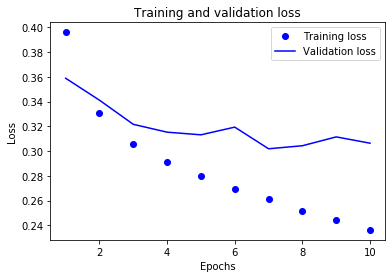

In [12]:
# 6. Loss, Accuracy 그래프 시각화
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [13]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3087 - acc: 0.8696
[0.30865487456321716, 0.8695607781410217]


In [16]:
!pip install gensim
import os

In [17]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 32)


In [18]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.tsv'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [19]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([ 0.00545231,  0.59479386, -0.5650456 ,  0.6148988 ,  0.49764812,
       -0.4592151 ,  0.87130654,  0.7049026 ,  0.0335626 ,  0.17589828,
        0.30301404, -0.04730422,  0.2827968 ,  0.43540958,  0.05599823,
        0.6517034 , -0.7126021 , -0.2606518 ,  0.13326332,  0.10878755,
       -0.19412017,  0.15452592, -0.5049098 ,  0.515646  ,  0.25049362,
        0.19701932, -0.46641982, -0.75827014, -0.198063  , -0.33578527,
       -0.16979237, -0.6211356 ], dtype=float32)

In [20]:
word_vectors.similar_by_word("사랑")

[('위대', 0.9734489917755127),
 ('비극', 0.9702250957489014),
 ('생각나', 0.9681748151779175),
 ('슬프', 0.9681433439254761),
 ('강렬', 0.9666721820831299),
 ('발견', 0.9660415649414062),
 ('귀여운', 0.9644383788108826),
 ('진실', 0.9632236957550049),
 ('감탄', 0.9625881910324097),
 ('빠져', 0.9623256325721741)]

In [21]:
from gensim.models import KeyedVectors, Word2Vec
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = Word2Vec.load(word2vec_path)
vector = word2vec['사랑']
vector     

/home/ssac12/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


array([-1.3740246 , -1.7353463 ,  3.3915305 , -2.569253  , -1.4016607 ,
        1.4556127 ,  0.9414557 ,  1.9207907 ,  0.16471806,  0.4838317 ,
       -0.8547181 ,  2.0879807 ,  0.86741775,  0.87539405, -0.09962013,
        0.22928311, -1.1858722 ,  0.00858838,  1.4999928 , -0.16196461,
       -0.35184434, -0.92390764,  1.0849575 ,  0.3025011 ,  2.7021565 ,
       -1.0263684 ,  0.32864776, -0.76589465, -2.510981  , -0.66225356,
        2.8434615 ,  0.50130975, -1.021874  , -1.4366034 ,  1.1110784 ,
        0.5812605 , -0.5830406 , -0.5785423 ,  1.3634988 ,  2.3074338 ,
       -1.4314893 ,  0.45745876,  1.1073523 , -3.2135262 , -0.2898375 ,
       -1.1622221 ,  1.2369208 , -0.7622987 , -0.37757635,  1.1376442 ,
        0.01065568, -0.69105595,  1.5159112 ,  1.1534518 , -1.0119992 ,
       -0.5757404 ,  1.1349088 , -1.1289831 ,  0.13004152,  2.0451715 ,
       -0.23940353,  1.3604902 ,  0.72700524,  0.32545742,  1.0612459 ,
        0.42252553,  1.1442151 ,  2.8774905 ,  2.4377263 , -1.34

In [23]:
#한국어 word2vec을 사용하고 나서 연관 단어가 더 잘 뜨는 것 확인 가능 
word2vec.similar_by_word("사랑")

/home/ssac12/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('슬픔', 0.7216663360595703),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985676765442),
 ('기쁨', 0.6458414793014526),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937871932983),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206068992614746),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [24]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/ssac12/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/ssac12/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [25]:
# 모델 2 Conv1D + MaxPooling
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [26]:
# 모델 3 MaxPooling
vocab_size = 20000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 100   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         2000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 2,000,817
Trainable params: 2,000,817
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

In [ ]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

참고 : https://wikidocs.net/44249